In [3]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
torch.__version__

'2.0.0+cu118'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Get some names from https://github.com/MASTREX/List-of-Indian-Names

In [7]:
!wget https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv -O names-long.csv

--2023-03-31 16:39:52--  https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85538 (84K) [text/plain]
Saving to: ‘names-long.csv’

names-long.csv      100%[===================>]  83.53K  --.-KB/s    in 0.07s   

2023-03-31 16:39:53 (1.19 MB/s) - ‘names-long.csv’ saved [85538/85538]



In [8]:
!head names-long.csv

,Name
0,aabid
1,aabida
2,aachal
3,aadesh
4,aadil
5,aadish
6,aaditya
7,aaenab
8,aafreen


In [9]:
words = pd.read_csv('names-long.csv')["Name"]
words = words.str.lower()
words = words.str.strip()
words = words.str.replace(" ", "")

words = words[words.str.len() > 2]
words = words[words.str.len() < 10]

# Randomly shuffle the words
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

# Remove words having non alphabets
words = [word for word in words if word.isalpha()]
words[:10]


['khushbu',
 'partyush',
 'shiwani',
 'shakun',
 'meenakshi',
 'raniya',
 'poonam',
 'chandini',
 'jabir',
 'gurnam']

In [10]:
len(words)

6184

In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [12]:
block_size = 4 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [13]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([44325, 4]), torch.int64, torch.Size([44325]), torch.int64)

In [17]:
# Embedding layer for the context

emb_dim = 2
emb = torch.nn.Embedding(len(stoi), emb_dim)


In [18]:
emb.weight

Parameter containing:
tensor([[-6.3959e-01, -1.7073e-01],
        [-1.7382e+00,  1.7466e-01],
        [-6.6321e-01,  4.1073e-01],
        [-1.6856e+00,  1.0051e+00],
        [ 1.0346e+00, -3.9237e-01],
        [ 9.7926e-01, -9.8037e-01],
        [ 6.1960e-01,  1.6536e-03],
        [-8.0376e-01, -1.8423e-01],
        [-8.7847e-01, -9.9468e-01],
        [-5.0439e-01,  2.1360e-01],
        [-1.7855e+00,  4.7049e-01],
        [-7.9968e-01, -6.4335e-01],
        [-1.1365e+00,  7.7208e-01],
        [-4.9984e-01, -7.7792e-01],
        [ 6.4796e-01, -3.1718e-03],
        [ 1.8831e-01,  1.6474e+00],
        [ 9.5616e-01, -1.0264e+00],
        [-1.3072e+00,  2.1557e+00],
        [ 1.0139e+00,  5.7146e-01],
        [-4.7440e-01, -4.6429e-01],
        [-7.4398e-01,  1.5965e-01],
        [ 2.0270e-01,  1.3207e-01],
        [-2.2629e-02,  3.5132e-01],
        [-5.5195e-01, -9.0722e-02],
        [ 2.0707e-01,  3.0502e-01],
        [-1.8043e+00,  4.0086e-02],
        [-4.1971e-01,  1.7808e+00]], requi

<AxesSubplot:>

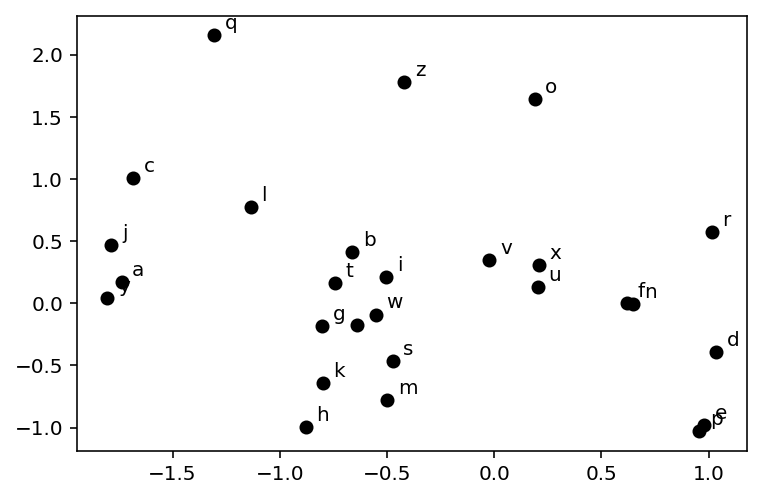

In [19]:
# Function to visualize the embedding in 2d space

def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        x, y = emb.weight[i].detach().cpu().numpy()
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

In [20]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = F.relu(self.lin1(x))
    x = self.lin2(x)
    return x
    

In [21]:
# Generate names from untrained model


model = NextChar(block_size, len(stoi), emb_dim, 50).to(device)

g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

njjnlvjpze
a
qiklym
lzeridzkyp
safkfxwloa
dabymmslou
llfanwytrp
fpyyyyjcty
ckzdcedwhy
afvymrxuhl


In [22]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

emb.weight torch.Size([27, 2])
lin1.weight torch.Size([50, 8])
lin1.bias torch.Size([50])
lin2.weight torch.Size([27, 50])
lin2.bias torch.Size([27])


In [23]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.001)
import time
# Mini-batch training
batch_size = 4096*16
print_every = 200
elapsed_time = []
for epoch in range(5000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())
        print("Time taken for 1 epochs: {} seconds".format(sum(elapsed_time)/print_every))


0 3.3009612560272217
Time taken for 1 epochs: 6.783246994018554e-05 seconds
200 2.64089035987854
Time taken for 1 epochs: 0.002798807621002197 seconds
400 2.464935779571533
Time taken for 1 epochs: 0.005505086183547974 seconds
600 2.3540990352630615
Time taken for 1 epochs: 0.008209853172302247 seconds
800 2.2896411418914795
Time taken for 1 epochs: 0.010902423858642579 seconds
1000 2.253048896789551
Time taken for 1 epochs: 0.01357825517654419 seconds
1200 2.230181932449341
Time taken for 1 epochs: 0.01625855326652527 seconds
1400 2.214463949203491
Time taken for 1 epochs: 0.018946928977966307 seconds
1600 2.2014658451080322
Time taken for 1 epochs: 0.021631813049316405 seconds
1800 2.189743995666504
Time taken for 1 epochs: 0.024313094615936278 seconds
2000 2.1792221069335938
Time taken for 1 epochs: 0.02699194073677063 seconds
2200 2.1697933673858643
Time taken for 1 epochs: 0.029654964208602905 seconds
2400 2.162414073944092
Time taken for 1 epochs: 0.032336957454681396 seconds
260

<AxesSubplot:>

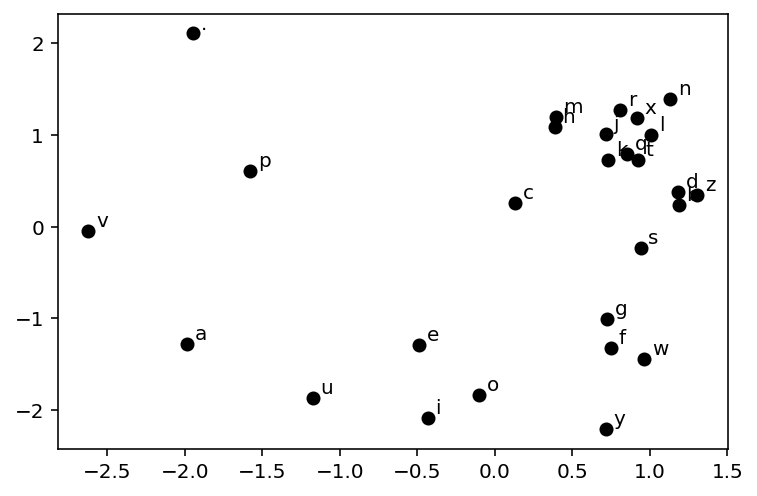

In [24]:
# Visualize the embedding

plot_emb(model.emb, itos)

In [31]:
import torchsummary

# Create a summary of the model

torchsummary.summary(model, X.shape)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [50]:
# Generate names from trained model

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

gendeepand
magb
jarved
naved
mair
suba
pahresh
mramaw
goley
srishalman


aabid


___ a
__a b
_aa b
aab i 
abi d 
bid _


__ a
_a a
aa b
ab i
bi d
id _
